In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt 
import LucaM185
device = torch.device("cuda:0" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")


In [6]:
with open("datasets/tinyShakespeare.txt", "r") as f:
    load = f.read()
print(load[:200])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you


In [7]:
texttoint = {elm: n for n, elm in enumerate(set(load))}
inttotext = {n:elm for n, elm in enumerate(set(load))}
dataset = [texttoint[c] for c in load]

vocab_size = len(texttoint)
sequence_length = 20

sequences = torch.tensor([dataset[i:-sequence_length+i-1] for i in range(sequence_length+1)]).T
inputs = sequences[2000:, :-1]
labels = sequences[2000:, -1]
val_inputs = sequences[:2000, :-1]
val_labels = sequences[:2000, -1]

When scaling the MLP for large sequences, the number of parameters grows rapidly. Modern LLMs like GPT-4 can handle up to 128,000 tokens (each token is typically 2-5 characters), indicating something is amiss. 

Our core issue is that the number of parameters depends on the input sequence length. To address this, we can design an very simple architecture, which maintains a hidden state and updates it with linear layers. By reusing the same layers repeatedly, we can scale the sequence length indefinitely. 

This approach processes embeddings with the same parameters for all time steps, avoiding the need for unique parameters at each step. (the positionality is learned by the model and progressively encoded in the hidden state)

Millions of parameters: 0.09
Step ___0 - Loss: 4.238 - Val Loss: 4.219
Step _300 - Loss: 2.675 - Val Loss: 2.390
Step _600 - Loss: 2.353 - Val Loss: 2.673
Step _900 - Loss: 2.244 - Val Loss: 1.997
Step 1200 - Loss: 2.153 - Val Loss: 1.888
Step 1500 - Loss: 2.305 - Val Loss: 2.565
Step 1800 - Loss: 1.927 - Val Loss: 1.934
Step 2100 - Loss: 2.444 - Val Loss: 2.137
Step 2400 - Loss: 1.990 - Val Loss: 2.408
Step 2700 - Loss: 1.908 - Val Loss: 2.006


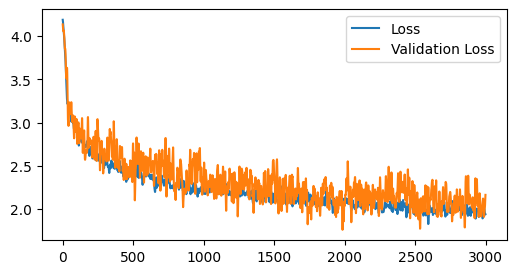

In [ ]:
class RNN(nn.Module):
    def __init__(self, emb_size, hidden_size):
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, emb_size)
        self.fcih = nn.Linear(emb_size, hidden_size)
        self.fchh = nn.Linear(hidden_size, hidden_size)
        self.fcho = nn.Linear(hidden_size, vocab_size) 
    
    def forward(self, inputs):
        emb = self.embeddings(inputs)
        state = torch.zeros(inputs.shape[0], self.fchh.weight.shape[0]).to(device) 
        
        for elm in range(emb.shape[1]):
            state = torch.tanh(self.fcih(emb[:, elm]) + self.fchh(state))

        return self.fcho(state)

model = RNN(emb_size=32, hidden_size=256).to(device)
print(f"Millions of parameters: {sum(p.numel() for p in model.parameters())/1e6:.2f}")

steps = 3000
batch_size = 128
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4) 

lossi = []
vlossi = []

for step in range(steps):
    indexes = torch.randint(0, len(inputs), (batch_size,))
    
    pred = model(inputs[indexes].to(device)) 
    loss = F.cross_entropy(pred, labels[indexes].to(device))

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    lossi.append(loss.item())
    
    with torch.no_grad():
        indexes = torch.randint(0, len(val_inputs), (batch_size//8,))
        pred = model(val_inputs[indexes].to(device))
        vloss = F.cross_entropy(pred, val_labels[indexes].to(device))
        vlossi.append(vloss.item())
        
    if step % (steps//10) == 0:
        print(f"Step {step:_>4d} - Loss: {loss.item():.3f} - Val Loss: {vloss.item():.3f}")


from scipy.ndimage import gaussian_filter1d
plt.figure(figsize=(6, 3))  
plt.plot(gaussian_filter1d(lossi, sigma=2), label='Loss')
plt.plot(gaussian_filter1d(vlossi, sigma=2), label='Validation Loss')
plt.legend()

# Multi Token Training

By calculating the loss at each time step, you're effectively turning a single sequence prediction into multiple label predictions, increasing the training signal. For the same computation, this gives you 20x the number of labels and updates, allowing the model to learn richer dependencies. This makes RNNs more efficient at handling long sequences by leveraging every step for learning.

In [9]:
texttoint = {elm: n for n, elm in enumerate(set(load))}
inttotext = {n:elm for n, elm in enumerate(set(load))}
dataset = [texttoint[c] for c in load]

vocab_size = len(texttoint)
sequence_length = 20

sequences = torch.tensor([dataset[i:-sequence_length+i-1] for i in range(sequence_length+1)]).T
inputs = sequences[2000:, :-1]
labels = sequences[2000:, 1:] 
# going from predicting the last character to predicting the next character at every step
# Note the difference between sequences[2000:, 1:] and sequences[2000:, -1] in the previous cell
val_inputs = sequences[:2000, :-1]
val_labels = sequences[:2000, 1:]

Millions of parameters: 0.09
Step ___0 - Loss: 4.247 - Val Loss: 4.216
Step _300 - Loss: 2.361 - Val Loss: 2.434
Step _600 - Loss: 2.137 - Val Loss: 2.229
Step _900 - Loss: 1.971 - Val Loss: 2.108
Step 1200 - Loss: 1.919 - Val Loss: 2.009
Step 1500 - Loss: 1.932 - Val Loss: 1.960
Step 1800 - Loss: 1.883 - Val Loss: 1.905
Step 2100 - Loss: 1.792 - Val Loss: 1.853
Step 2400 - Loss: 1.735 - Val Loss: 1.826
Step 2700 - Loss: 1.767 - Val Loss: 1.796


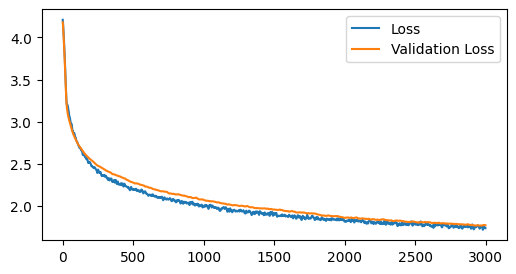

In [ ]:
class RNN(nn.Module):
    def __init__(self, emb_size, hidden_size):
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, emb_size)
        self.fcxh = nn.Linear(emb_size, hidden_size)
        self.fchh = nn.Linear(hidden_size, hidden_size)
        self.fcxy = nn.Linear(hidden_size, vocab_size) 

    def forward(self, inputs):
        emb = self.embeddings(inputs) 
        state = torch.zeros(inputs.shape[0], self.fchh.weight.shape[0]).to(device) 
        
        out = []
        for elm in range(emb.shape[1]):
            state = torch.tanh(self.fcxh(emb[:, elm]) + self.fchh(state))
            out.append(self.fcxy(state))
            
        return torch.stack(out[:], dim=1) # (batch_size, sequence_length, hidden_size) 


model = RNN(emb_size=32, hidden_size=256).to(device)
print(f"Millions of parameters: {sum(p.numel() for p in model.parameters())/1e6:.2f}")

steps = 3000
batch_size = 128
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)  

lossi = []
vlossi = []

for step in range(steps):
    indexes = torch.randint(0, len(inputs), (batch_size,))
    
    pred = model(inputs[indexes].to(device)) 
    loss = F.cross_entropy(pred.view(-1, vocab_size), labels[indexes].to(device).view(-1))

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    with torch.no_grad():
        pred = model(val_inputs.to(device))
        vloss = F.cross_entropy(pred.reshape(-1, vocab_size), val_labels.to(device).reshape(-1))
        vlossi.append(vloss.item())

    lossi.append(loss.item())
    if step % (steps//10) == 0:
        print(f"Step {step:_>4d} - Loss: {loss.item():.3f} - Val Loss: {vloss.item():.3f}")


from scipy.ndimage import gaussian_filter1d
plt.figure(figsize=(6, 3))  
plt.plot(gaussian_filter1d(lossi, sigma=2), label='Loss')
plt.plot(gaussian_filter1d(vlossi, sigma=2), label='Validation Loss')
plt.legend()

In [11]:
sequence_lengths = [1, 2, 4, 8, 16, 32, 64, 128, 256]
losses = []
vlosses = []

for sequence_length in sequence_lengths:
    texttoint = {elm: n for n, elm in enumerate(set(load))}
    inttotext = {n:elm for n, elm in enumerate(set(load))}
    dataset = [texttoint[c] for c in load]

    vocab_size = len(texttoint)

    sequences = torch.tensor([dataset[i:-sequence_length+i-1] for i in range(sequence_length+1)]).T
    inputs = sequences[2000:, :-1]
    labels = sequences[2000:, 1:] 
    # going from predicting the last character to predicting the next character at every step
    # Note the difference between sequences[2000:, 1:] and sequences[2000:, -1] in the previous cell
    val_inputs = sequences[:2000, :-1]
    val_labels = sequences[:2000, 1:]

    model = RNN(emb_size=32, hidden_size=256).to(device)

    steps = 3000
    batch_size = 128
    optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)  # 3e-4 is a good learning rate for Adam on big models

    lossi = []
    vlossi = []

    for step in range(steps):
        indexes = torch.randint(0, len(inputs), (batch_size,))
        
        pred = model(inputs[indexes].to(device)) 
        loss = F.cross_entropy(pred.view(-1, vocab_size), labels[indexes].to(device).view(-1))

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        lossi.append(loss.item())
        
        with torch.no_grad():
            pred = model(val_inputs.to(device))
            vloss = F.cross_entropy(pred.reshape(-1, vocab_size), val_labels.to(device).reshape(-1))
            vlossi.append(vloss.item())

    print(f"Processed sequence length: {sequence_length:_>3d}, loss: {sum(lossi[-100:])/100:.3f}, validation loss: {sum(vlossi[-100:])/100:.3f}")
    losses.append(lossi)
    vlosses.append(vlossi)


Processed sequence length: __1, loss: 2.518, validation loss: 2.594
Processed sequence length: __2, loss: 2.321, validation loss: 2.397
Processed sequence length: __4, loss: 2.132, validation loss: 2.202
Processed sequence length: __8, loss: 1.941, validation loss: 1.976
Processed sequence length: _16, loss: 1.786, validation loss: 1.809
Processed sequence length: _32, loss: 1.683, validation loss: 1.695
Processed sequence length: _64, loss: 1.601, validation loss: 1.618
Processed sequence length: 128, loss: 1.548, validation loss: 1.582
Processed sequence length: 256, loss: 1.504, validation loss: 1.528


We get severly limited return on out increase of sequence length. So we can try to optimize our architecture to make it better

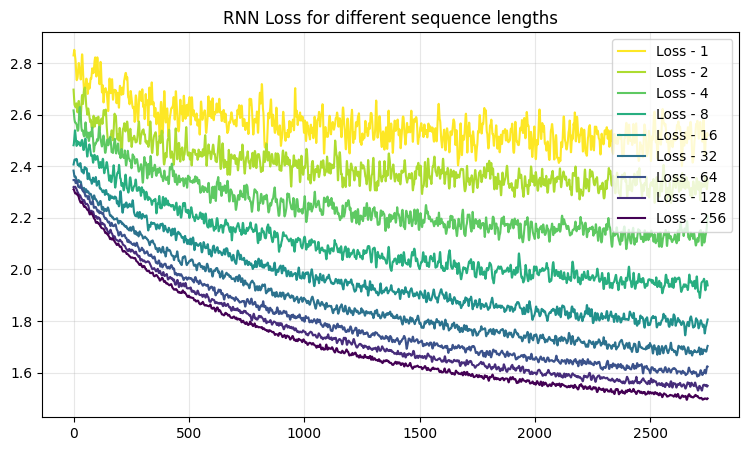

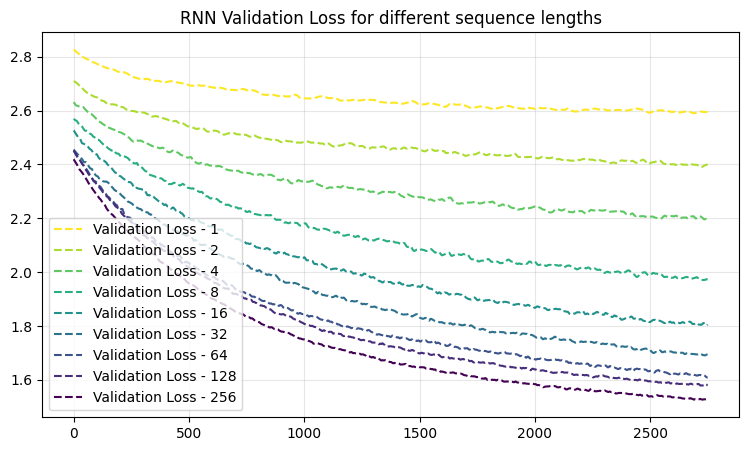

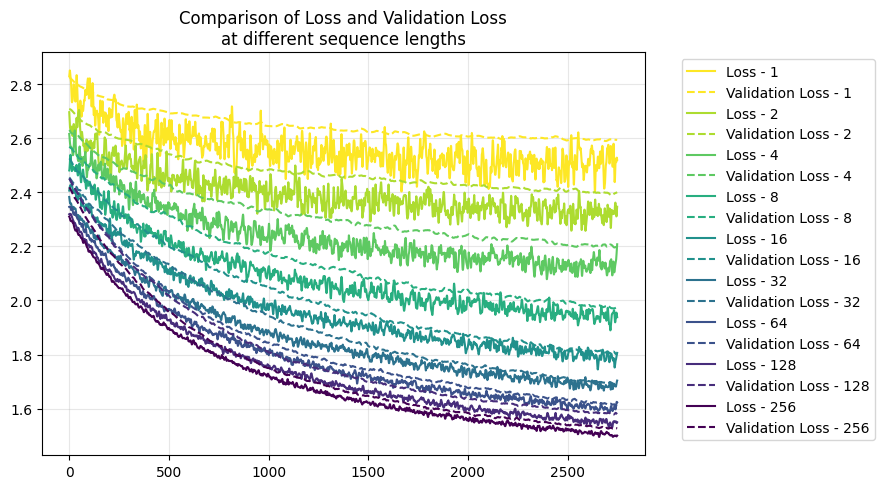

In [12]:
import numpy as np

plt.figure(figsize=(9, 5))
colors = plt.cm.viridis(np.linspace(1, 0, len(sequence_lengths)))

for loss, vloss, sequence_length, color in zip(losses, vlosses, sequence_lengths, colors):
    plt.plot(gaussian_filter1d(loss[250:], sigma=2), label=f"Loss - {sequence_length}", color=color)

plt.title("RNN Loss for different sequence lengths")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

plt.figure(figsize=(9, 5))
for loss, vloss, sequence_length, color in zip(losses, vlosses, sequence_lengths, colors):
    plt.plot(gaussian_filter1d(vloss[250:], sigma=2), label=f"Validation Loss - {sequence_length}", linestyle='--', color=color)

plt.title("RNN Validation Loss for different sequence lengths")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

plt.figure(figsize=(9, 5))
for loss, vloss, sequence_length, color in zip(losses, vlosses, sequence_lengths, colors):
    plt.plot(gaussian_filter1d(loss[250:], sigma=2), label=f"Loss - {sequence_length}", color=color)
    plt.plot(gaussian_filter1d(vloss[250:], sigma=2), label=f"Validation Loss - {sequence_length}", linestyle='--', color=color)

plt.title("Comparison of Loss and Validation Loss\nat different sequence lengths")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


# LSTM 
The key difference between an RNN and an LSTM lies in their handling of the hidden state. An RNN updates the hidden state using a simple activation function, which can struggle with long-term dependencies due to vanishing gradients. In contrast, an LSTM introduces a more complex cell state and gates (input, forget, and output), allowing it to better retain and regulate information over long sequences, improving its ability to capture long-term dependencies.

In practice this implementation will perform on par with an RNN with the same low sequence length. If you want to see a performance gap between the two, you should experiment with longer sequences and possibly with a more interesting dataset. 

In [13]:
texttoint = {elm: n for n, elm in enumerate(set(load))}
inttotext = {n:elm for n, elm in enumerate(set(load))}
dataset = [texttoint[c] for c in load]

vocab_size = len(texttoint)

sequence_length = 50
sequences = torch.tensor([dataset[i:-sequence_length+i-1] for i in range(sequence_length+1)]).T
inputs = sequences[2000:, :-1]
labels = sequences[2000:, 1:] 
val_inputs = sequences[:2000, :-1]
val_labels = sequences[:2000, 1:]


In [14]:

class LSTM(nn.Module):
    def __init__(self, emb_size, hidden_size):
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, emb_size)
        self.ui = nn.Linear(emb_size, hidden_size)
        self.uf = nn.Linear(emb_size, hidden_size)
        self.uo = nn.Linear(emb_size, hidden_size)
        self.ug = nn.Linear(emb_size, hidden_size)
        self.wi = nn.Linear(hidden_size, hidden_size)
        self.wf = nn.Linear(hidden_size, hidden_size)
        self.wo = nn.Linear(hidden_size, hidden_size)
        self.wg = nn.Linear(hidden_size, hidden_size)
        self.fcxy = nn.Linear(hidden_size, vocab_size)  # Add output layer

    def forward(self, inputs):
        emb = self.embeddings(inputs)
        state = torch.zeros(inputs.shape[0], self.wf.out_features).to(device)
        cell = torch.zeros(inputs.shape[0], self.wf.out_features).to(device)
        states = torch.zeros(inputs.shape[0], inputs.shape[1], self.wf.out_features).to(device)

        out = []
        for elm in range(emb.shape[1]):
            i = torch.sigmoid(self.ui(emb[:, elm]) + self.wi(state))
            f = torch.sigmoid(self.uf(emb[:, elm]) + self.wf(state))
            o = torch.sigmoid(self.uo(emb[:, elm]) + self.wo(state))
            g = torch.tanh(self.ug(emb[:, elm]) + self.wg(state))
            cell = f * cell + i * g
            state = o * torch.tanh(cell)
            states[:, elm] = state
            out.append(self.fcxy(state))

        return torch.stack(out[:], dim=1)
        
    
model = LSTM(emb_size=32, hidden_size=256).to(device)
print(f"Millions of parameters: {sum(p.numel() for p in model.parameters())/1e6:.2f}")

steps = 3000
batch_size = 128
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)  # 3e-4 is a good learning rate for Adam on big models

lossi = []
vlossi = []

for step in range(steps):
    indexes = torch.randint(0, len(inputs), (batch_size,))
    
    pred = model(inputs[indexes].to(device)) 
    loss = F.cross_entropy(pred, labels[indexes].to(device))

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    lossi.append(loss.item())
    
    with torch.no_grad():
        indexes = torch.randint(0, len(val_inputs), (batch_size//8,))
        pred = model(val_inputs[indexes].to(device))
        vloss = F.cross_entropy(pred, val_labels[indexes].to(device))
        vlossi.append(vloss.item())
        
    if step % (steps//10) == 0:
        print(f"Step {step:_>4d} - Loss: {loss.item():.3f} - Val Loss: {vloss.item():.3f}")


from scipy.ndimage import gaussian_filter1d
plt.figure(figsize=(6, 3))  
plt.title("LSTM Loss")
plt.plot(gaussian_filter1d(lossi, sigma=2), label='Loss')
plt.plot(gaussian_filter1d(vlossi, sigma=2), label='Validation Loss')
plt.legend()

Millions of parameters: 0.32


RuntimeError: Expected target size [128, 65], got [128, 50]

# Sequential is slow
RNNs and LSTMs are inharently sequential in nature, they process one input token at a time. 
CPUs have compute units extremely optimized to run sequential calculations as fast as possible, but there is a limit dictated by physics, and to get around it we usually build many compute units that can work in parallel. 

Note: to go fast, CPUs try to find parallelism in supposedly sequential instructions and try to run them at the same time to maximise performance (see branch prediction/speculative execution). This workload instead is inharently sequential in nature so even CPUs are inadequate. 

GPUs have thousands of processors working in parallel connected to lots of memory at very high bandwidth. This is why we often prefer to do more calculations in parallel than less in series, it's just faster because of the nature of the hardware. 
In particular, Linear layers with big batch sizes are very fast. 